In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import shap
import xgboost as xgb
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold

In [2]:
def create_model(x_train, y_train, x_test, y_test):
    # Initialize model
    xg_reg = xgb.XGBRegressor(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                    max_depth = 5, alpha = 10, n_estimators = 50)
    # Fit model
    xg_reg.fit(x_train, y_train)
    
    # Make Predictions
    predictions = xg_reg.predict(x_test)
    
    # Extract ROC Curve data 
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, drop_intermediate=False)
    print('AUC: {}'.format(metrics.auc(fpr, tpr)))
    
    # Plot the ROC Curve
    temp_thresh = thresholds
    temp_thresh[0] = thresholds[0]-1
    plt.scatter(fpr, tpr, c=temp_thresh, cmap = cm.rainbow)
    plt.suptitle('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    cbar = plt.colorbar()
    cbar.set_label('Decision Threshold')
    plt.show()
    
    # Plot Feature Importance
    explainer = shap.TreeExplainer(xg_reg)
    shap_values = explainer.shap_values(x_train)
    shap.summary_plot(shap_values, x_train)
    
    return {'model': xg_reg, 'auc': metrics.auc(fpr, tpr), 'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds}

In [3]:
df = pd.read_csv('Pitching.csv')
df.columns

Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'W', 'L', 'G', 'GS',
       'CG', 'SHO', 'SV', 'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp',
       'ERA', 'IBB', 'WP', 'HBP', 'BK', 'BFP', 'GF', 'R', 'SH', 'SF', 'GIDP'],
      dtype='object')

In [4]:
# Restrict attention to data year 2000 and after.
df = df[df['yearID'] > 1999]


Unfortunately, the data does not provide info regarding what kind of pitcher the player is. Given that the goals, methods, and statistics of starters, middle-relief, and closers tend to be very different, it is a good idea to attempt to separate them in the data. For now let's focus on starting pitchers. 

It is reasonable to assume that a starting pitcher should be averaging about 5 innings, so we will restrict our attention to pitchers who average at least 14 outs to give our pitchers a little bit of leeway.

In [5]:
# Isolate Starting Pitchers.
df['Outs_Per_Appearance'] = df['IPouts']/df['G']
df = df[df['Outs_Per_Appearance'] >= 14]

In [6]:
# For the purposes of visualization, split the data into NL and AL dataframes.
df_NL = df[df['lgID'] == 'NL']
df_AL = df[df['lgID'] == 'AL']

# Restrict our attention to quantitative statistics.
quantitative_statistics = ['W', 'L', 'G', 'GS',
       'CG', 'SHO', 'SV', 'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp',
       'ERA', 'IBB', 'WP', 'HBP', 'BK', 'BFP', 'GF', 'R', 'SH', 'SF', 'GIDP']

descriptive_titles = {'W': 'Wins', 'L': 'Losses', 'G': 'Games', 'GS': 'Games Started', 'CG': 'Complete Games', 'SHO': 'Shutouts',
                     'SV': 'Saves', 'IPouts': 'Outs Pitched', 'H': 'Hits', 'ER': 'Earned Runs', 'HR': 'Home Runs', 'BB': 'Walks',
                     'SO': 'Strikeouts', 'BAOpp': 'Opponent Batting Average', 'ERA': 'Earned Run Average', 'IBB': 'Intentional Walks',
                     'WP': 'Wild Pitches', 'HBP': 'Batters Hit By Pitch', 'BK': 'Balks', 'BFP': 'Batters Faced By Pitcher', 'GF': 'Games Finished',
                     'R': 'Runs Allowed', 'SH': 'Sacrifices by Opposing Batters', 'SF': 'Sac Flies by Opposing Batters', 'GIDP': 'Grounded Into Double Plays by Opposing Batters'}


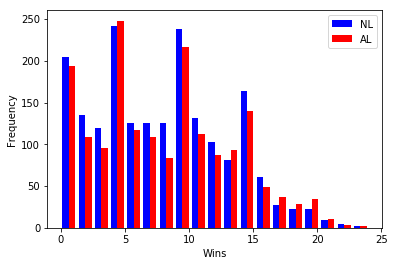

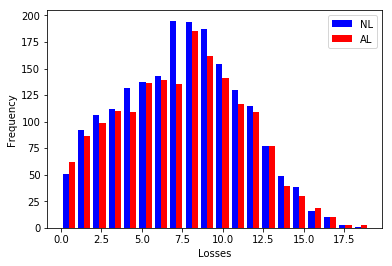

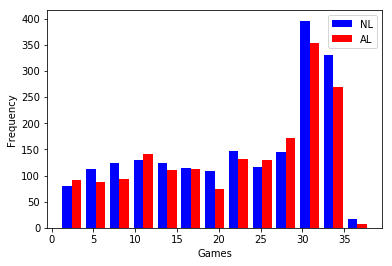

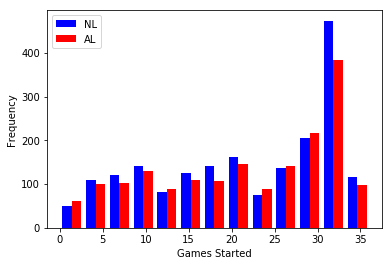

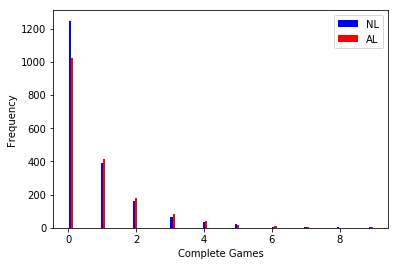

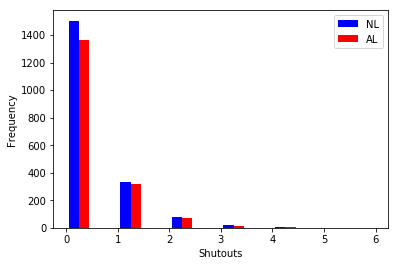

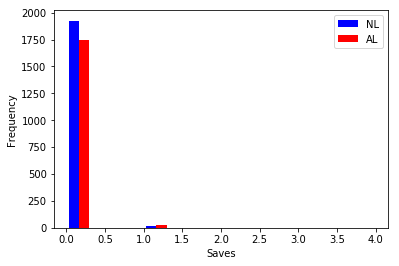

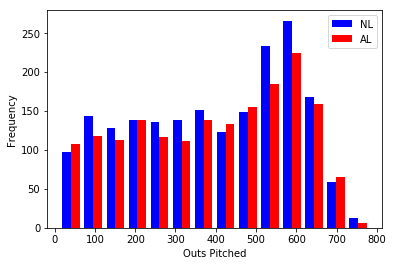

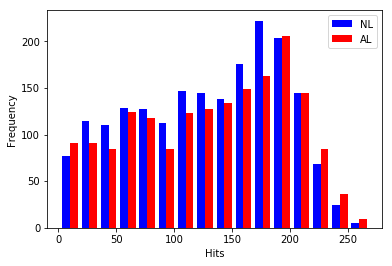

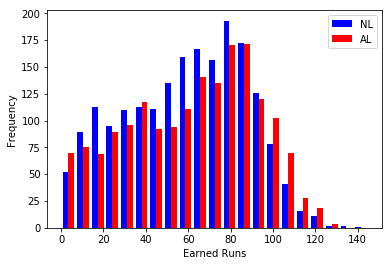

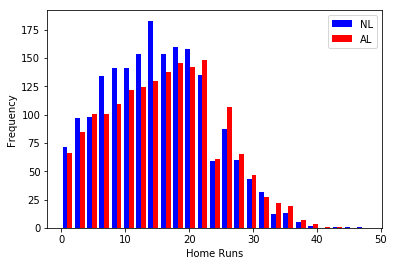

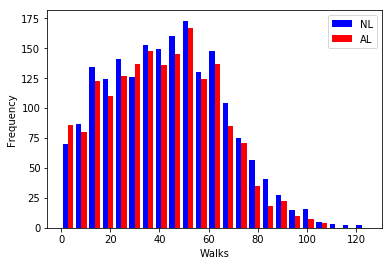

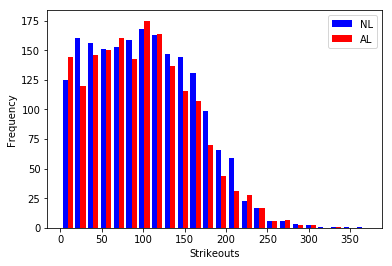

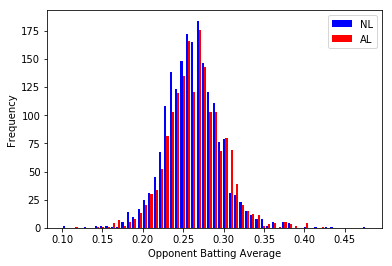

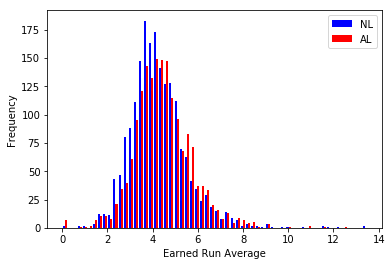

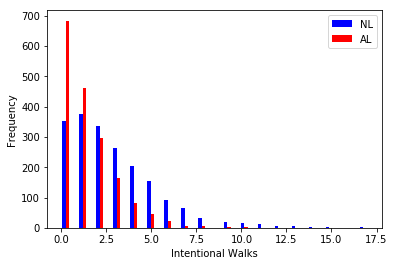

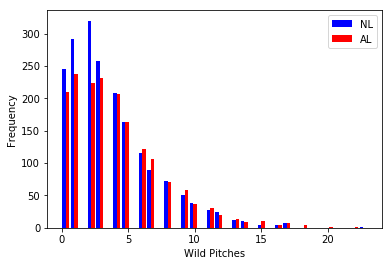

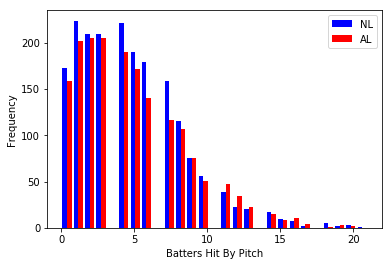

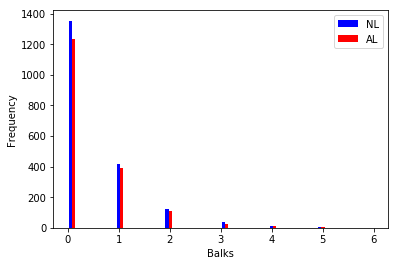

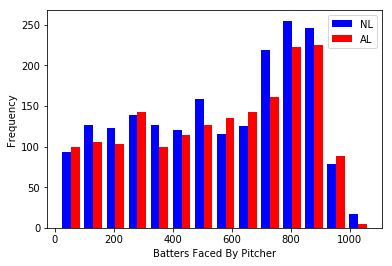

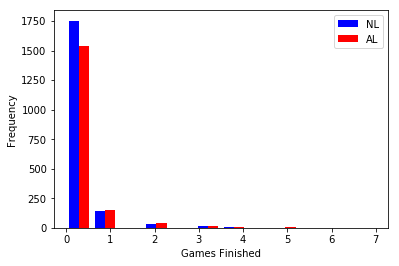

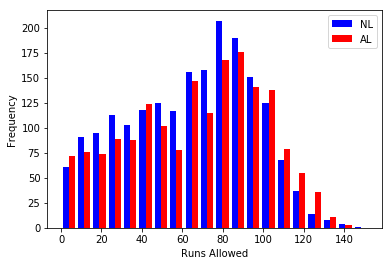

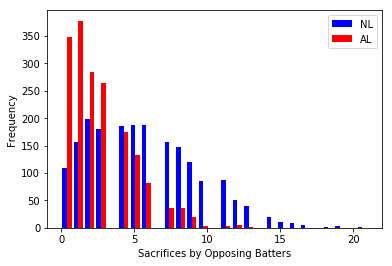

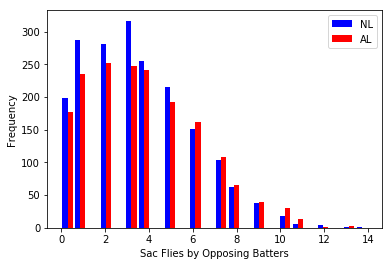

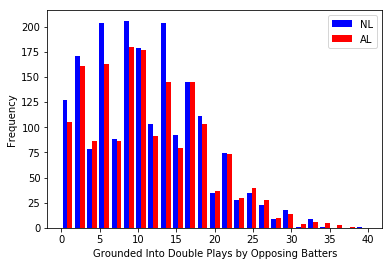

In [7]:
# Histograms comparing statistics for NL and AL starting pitchers.

for column_title in quantitative_statistics:
    plt.hist([df_NL[column_title], df_AL[column_title]], bins='auto', color=['blue','red'], label=['NL','AL'])
    plt.legend(prop={'size':10})
    plt.xlabel(descriptive_titles[column_title])
    plt.ylabel('Frequency')
    plt.show()

Some interesting differences occur. Notice that the National League seems to have a higher prevalence of sacrificial batting (bunting, for example) and intentional walks. The sacrificial batting might be explained by how often pitchers bunt along with the fact that pitchers don't bat in the American League.

In [8]:
X = df[['W', 'L', 'G', 'GS',
       'CG', 'SHO', 'SV', 'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp',
       'ERA', 'IBB', 'WP', 'HBP', 'BK', 'BFP', 'GF', 'R', 'SH', 'SF', 'GIDP']]
y = df['lgID']
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
label_encoder = preprocessing.LabelEncoder()
y = label_encoder.fit_transform(y)

# Split data into training and test sets.
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

[22:11:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC: 0.863039836865487


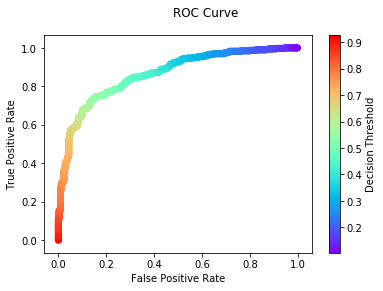

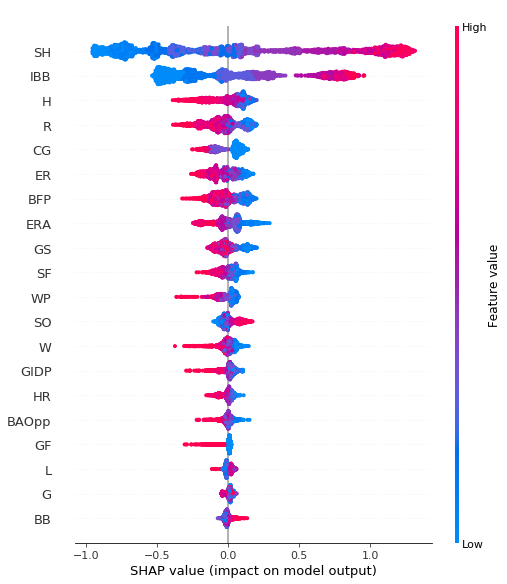

In [9]:
model_dict = create_model(x_train, y_train, x_test, y_test)

Above we see the ROC Curve as well as a plot of the importance of the features to the model. Unsurprisingly 'SH' and 'IBB' (sacrificial hits and intentional walks) are at the top in terms of importance, just as our exploration before suggested they might be.

Below cross-validation is implemented ensure robustness of the model. Overall, I am pleased with the performance of the model with the average AUC below clocking in at around 0.87.

[22:11:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC: 0.8703241895261845


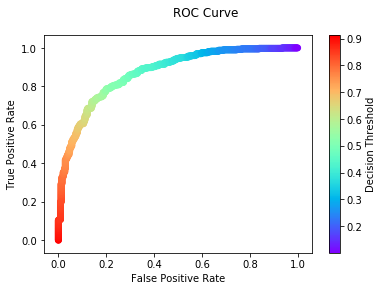

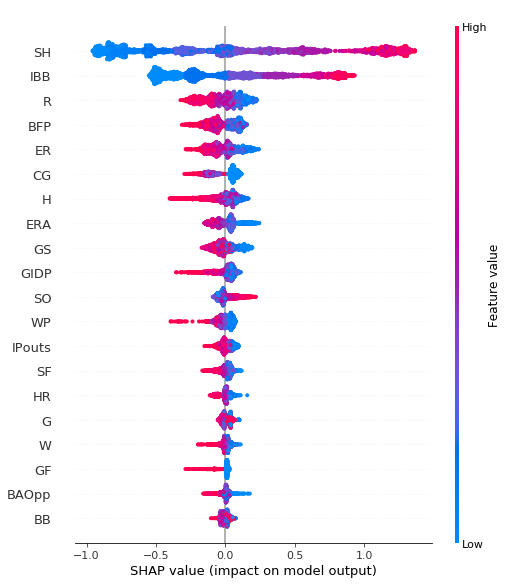

[22:11:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC: 0.8703241895261845


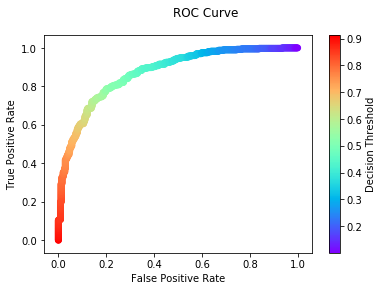

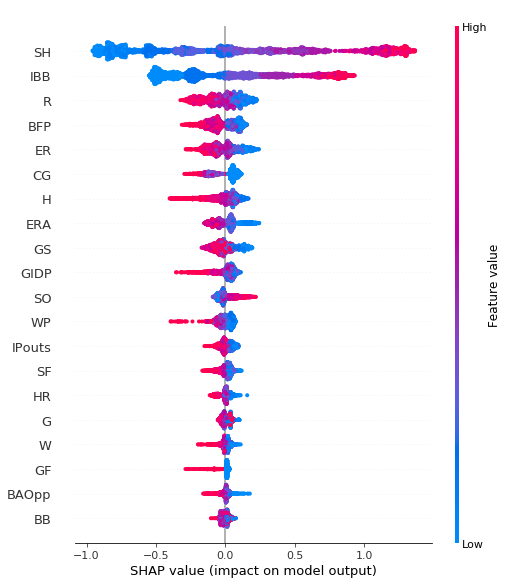

[22:11:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC: 0.8782804870960242


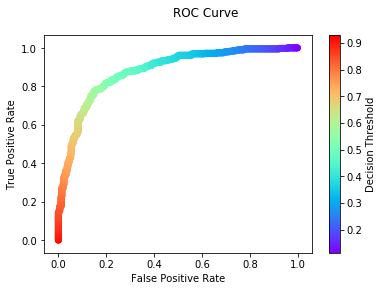

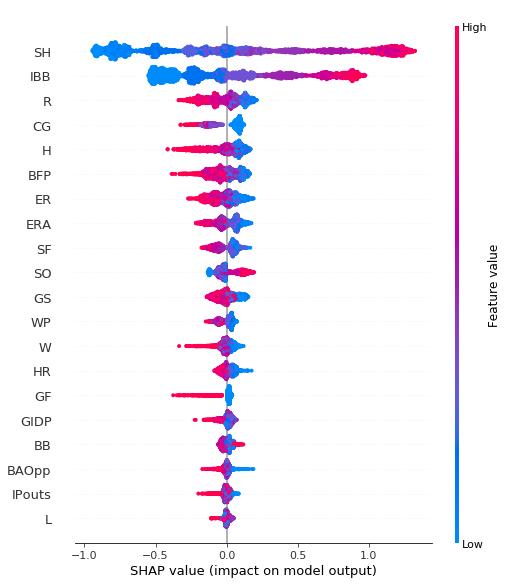

[22:11:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC: 0.8782804870960242


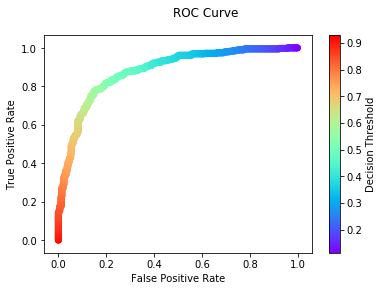

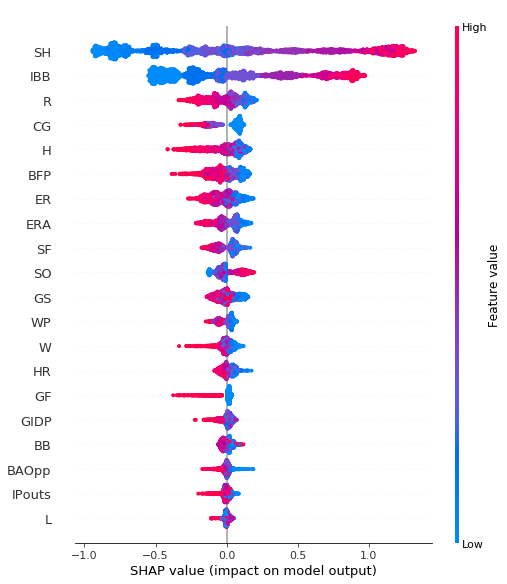

[22:11:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC: 0.8864833406081769


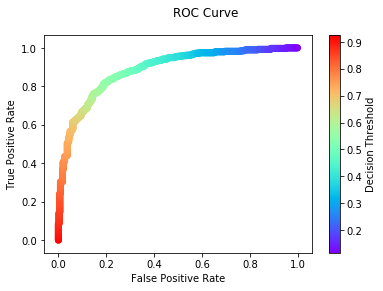

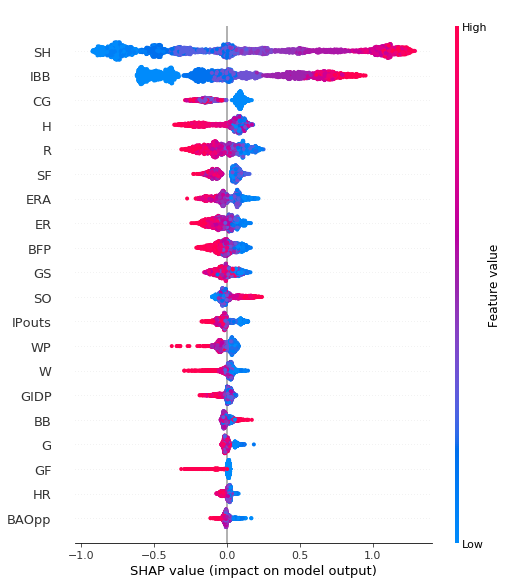

[22:11:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC: 0.8864833406081769


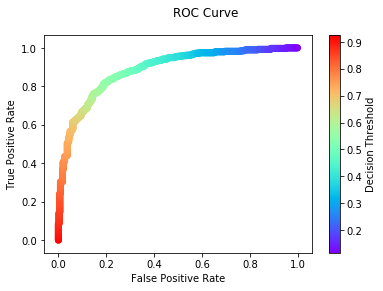

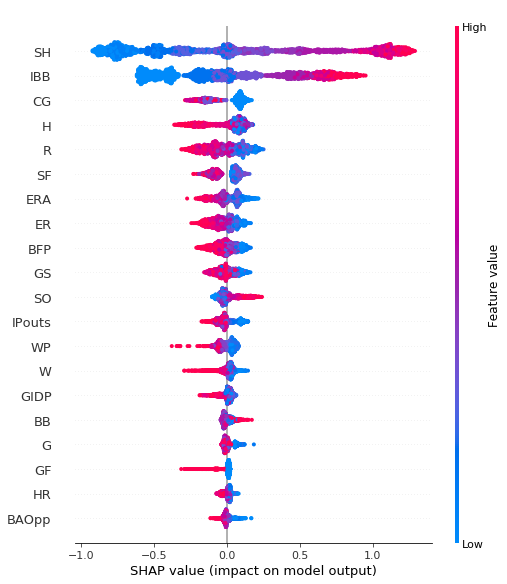

[22:11:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC: 0.8556149732620322


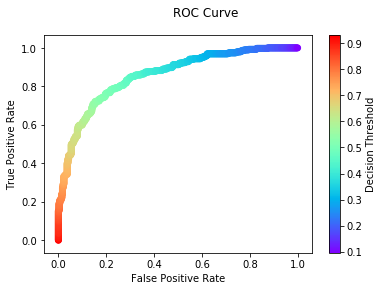

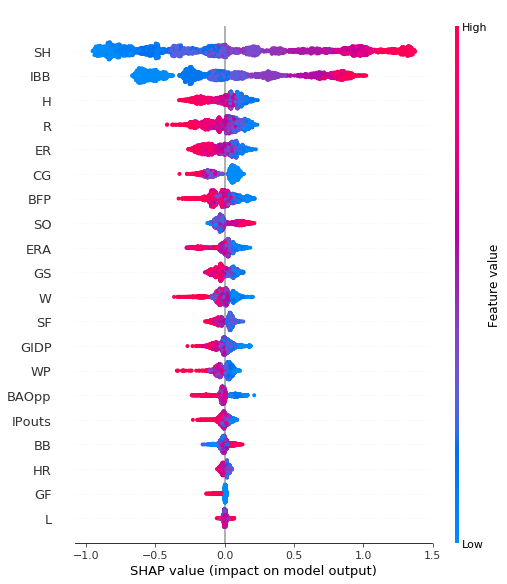

[22:11:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC: 0.8556149732620322


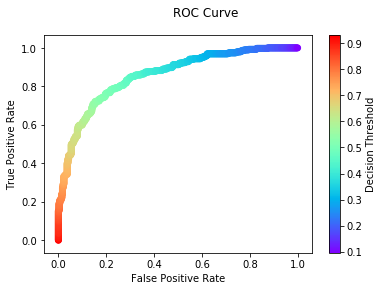

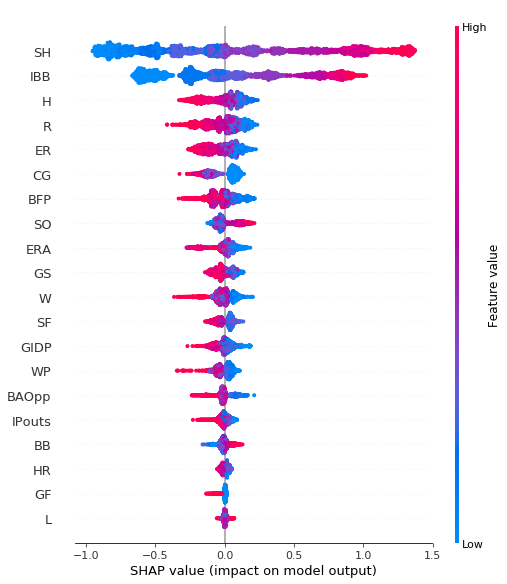

[22:11:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC: 0.8518591197162626


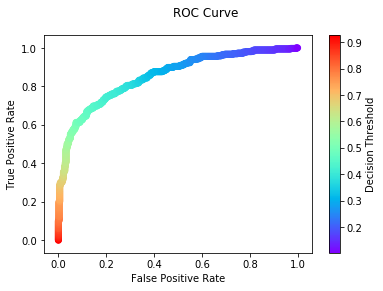

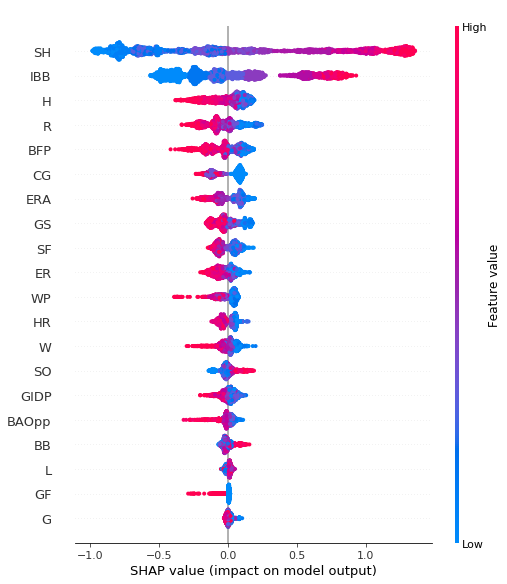

[22:11:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC: 0.8518591197162626


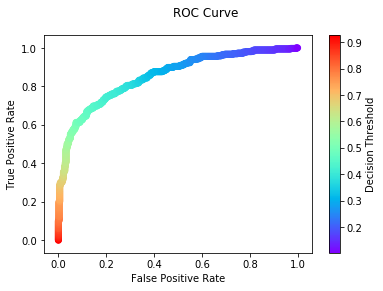

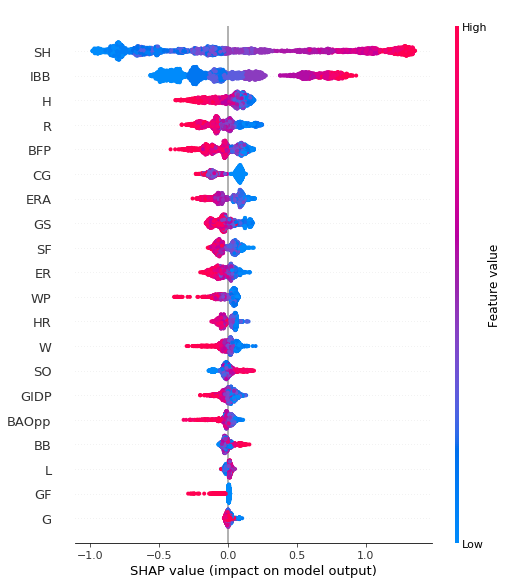

In [10]:
kf = KFold(n_splits=5)
cv_results = []
for train_index, test_index in kf.split(X):
    x_train, x_test = X.loc[train_index,:], X.loc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    model, model_auc, false_pos, true_pos, thresholds = create_model(x_train, y_train, x_test, y_test)
    cv_results.append(create_model(x_train, y_train, x_test, y_test))

In [11]:
print('Average AUC: {}'.format(np.average([x['auc'] for x in cv_results])))

Average AUC: 0.8685124220417361


In [12]:
np.std([x['auc'] for x in cv_results])

0.013155441260656093